In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .getOrCreate()


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pyspark.sql.functions import concat, col, lit, to_date

In [3]:
def castColumn(df, field, cast_type):
    return df \
        .withColumn(field + '_tmp', df[field].cast(cast_type)) \
        .drop(field) \
        .withColumnRenamed(field + '_tmp', field) 

In [4]:
def process_df(df):
    df = df \
        .filter(df.ArrDelay != "NA") \
        .filter(df.DepTime != "NA") \
        .filter(df.CRSDepTime != "NA") \
        .filter(df.CRSArrTime != "NA") \
        .withColumn('Date', to_date(concat(col("Year"), lit("-"), col("Month"), lit('-'), col('DayofMonth'))))
    df = castColumn(df, 'ArrDelay', 'int')
    df = castColumn(df, 'DepDelay', 'int')
    df = castColumn(df, 'CRSElapsedTime', 'int')
    df = castColumn(df, 'Distance', 'int')
    df = castColumn(df, 'TaxiOut', 'int')
    return df

In [5]:
df_small = spark.read.csv("../data/2007_small.csv",header=True)
df_big = spark.read.csv("../data/2007.csv",header=True)
df_massive = spark.read.csv("../data/2006.csv",header=True) \
                .union(df_big) \
                .union(spark.read.csv("../data/2008.csv",header=True))

df_small = process_df(df_small)
df_big = process_df(df_big)
df_massive = process_df(df_massive)

df_small.createOrReplaceTempView("df_small")
df_big.createOrReplaceTempView("df_big")
df_massive.createOrReplaceTempView("df_massive")

In [6]:
qeq_outliers = spark.sql("select * from df_big where ArrDelay > 175")
qeq_outliers.createOrReplaceTempView("qeq_outliers")

In [27]:
ad = pd.to_numeric(df_big.select("ArrDelay").filter(df_big.ArrDelay != "NA").toPandas()['ArrDelay'])

{'whiskers': [<matplotlib.lines.Line2D at 0x115c7a518>,
 'caps': [<matplotlib.lines.Line2D at 0x115c7aba8>,
 'boxes': [<matplotlib.lines.Line2D at 0x115c7a128>],
 'medians': [<matplotlib.lines.Line2D at 0x115c7afd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1181c65c0>],
 'means': []}

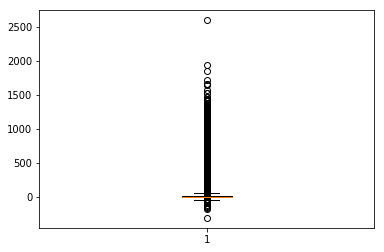

In [31]:
plt.boxplot(ad)

In [47]:
adg = spark.sql("select ArrDelay, count(*) from df_big group by ArrDelay").toPandas()

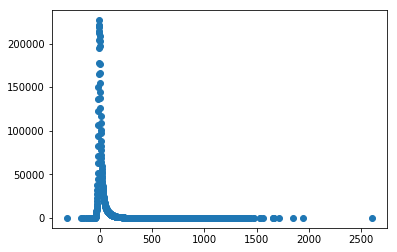

In [52]:
plt.scatter(pd.to_numeric(adg['ArrDelay']), adg['count(1)'])

In [14]:
adg_noo = spark.sql("select ArrDelay, count(*) from df_big where Dest != 'ORD' and Origin != 'ORD' group by ArrDelay").toPandas()

Py4JJavaError: An error occurred while calling o333.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 14.0 failed 1 times, most recent failure: Lost task 4.0 in stage 14.0 (TID 648, localhost, executor driver): java.io.FileNotFoundException: /private/var/folders/3p/2tl8fq012x5dlj7zwn0k2wcr0000gn/T/blockmgr-28af2355-1c2a-46cc-a3be-ce11c4d95a96/07/temp_shuffle_e53a1e37-f84c-4587-954c-a19e4b2f414e (Too many open files)
	at java.io.FileOutputStream.open(Native Method)
	at java.io.FileOutputStream.<init>(FileOutputStream.java:213)
	at org.apache.spark.storage.DiskBlockObjectWriter.initialize(DiskBlockObjectWriter.scala:103)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:116)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:237)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:151)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:299)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3258)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3255)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3365)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3364)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3255)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:483)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.io.FileNotFoundException: /private/var/folders/3p/2tl8fq012x5dlj7zwn0k2wcr0000gn/T/blockmgr-28af2355-1c2a-46cc-a3be-ce11c4d95a96/07/temp_shuffle_e53a1e37-f84c-4587-954c-a19e4b2f414e (Too many open files)
	at java.io.FileOutputStream.open(Native Method)
	at java.io.FileOutputStream.<init>(FileOutputStream.java:213)
	at org.apache.spark.storage.DiskBlockObjectWriter.initialize(DiskBlockObjectWriter.scala:103)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:116)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:237)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:151)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [ ]:
plt.scatter(pd.to_numeric(adg_noo['ArrDelay']), adg_noo['count(1)'])

In [11]:
df_big.count()

7275288

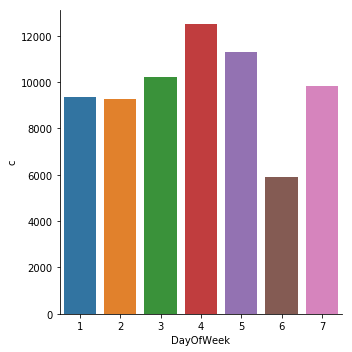

In [25]:
outliers_day = spark.sql('select DayOfWeek, count(*) as c from qeq_outliers group by DayOfWeek').toPandas()
sns.catplot(x="DayOfWeek", y="c", kind="bar", data=outliers_day)

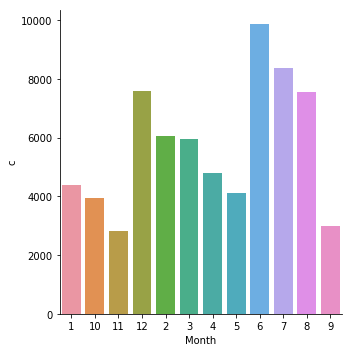

In [27]:
outliers_month = spark.sql('select Month, count(*) as c from qeq_outliers group by Month').toPandas()
sns.catplot(x="Month", y="c", kind="bar", data=outliers_month)

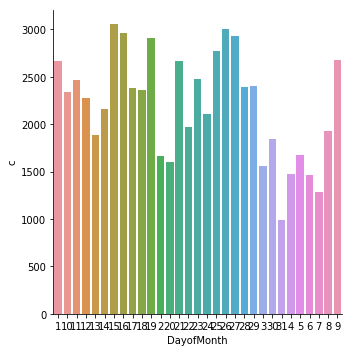

In [28]:
outliers_dayofmonth = spark.sql('select DayofMonth, count(*) as c from qeq_outliers group by DayofMonth').toPandas()
sns.catplot(x="DayofMonth", y="c", kind="bar", data=outliers_dayofmonth)

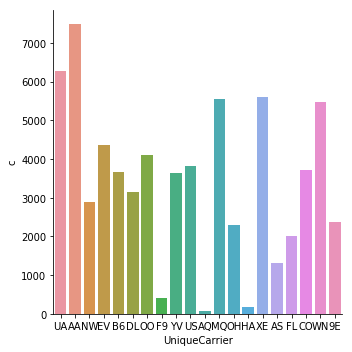

In [29]:
outliers_carrier = spark.sql('select UniqueCarrier, count(*) as c from qeq_outliers group by UniqueCarrier').toPandas()
sns.catplot(x="UniqueCarrier", y="c", kind="bar", data=outliers_carrier)

In [9]:
outliers_flightnum = spark.sql('select FlightNum, count(*) as c from qeq_outliers group by FlightNum order by c desc limit 20').toPandas()

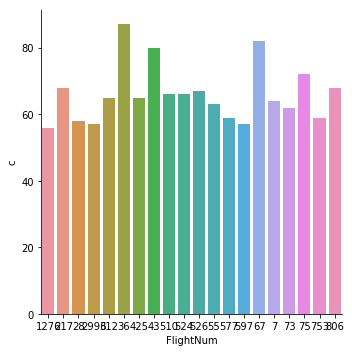

In [10]:
sns.catplot(x="FlightNum", y="c", kind="bar", data=outliers_flightnum)

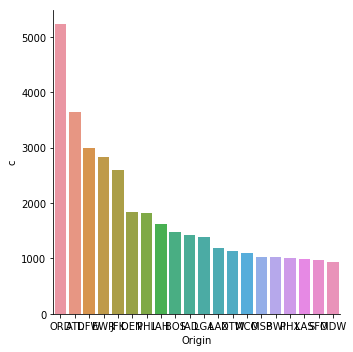

In [11]:
outliers_origin = spark.sql('select Origin, count(*) as c from qeq_outliers group by Origin order by c desc limit 20').toPandas()
sns.catplot(x="Origin", y="c", kind="bar", data=outliers_origin)

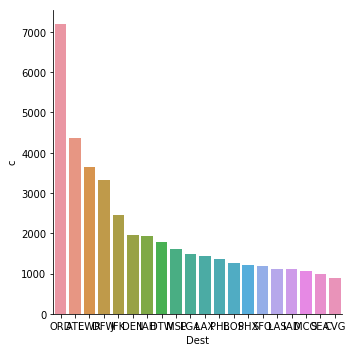

In [12]:
outliers_dest = spark.sql('select Dest, count(*) as c from qeq_outliers group by Dest order by c desc limit 20').toPandas()
sns.catplot(x="Dest", y="c", kind="bar", data=outliers_dest)

In [13]:
outliers_dest.head()

,Dest,c
0,ORD,7187
1,ATL,4355
2,EWR,3638
3,DFW,3315
4,JFK,2449


In [55]:
print(np.mean(ad))
print(np.median(ad))

10.19218057072105
0.0


In [90]:
df_big.corr('DepDelay', 'ArrDelay')

0.9315028109819367

In [88]:
df_big.corr('CRSElapsedTime', 'ArrDelay')

0.0054417055786659735

In [87]:
df_big.corr('Distance', 'ArrDelay')

-0.0017171179099961672

In [89]:
df_big.corr('TaxiOut', 'ArrDelay')

0.3263614338001894

In [86]:
jan = spark.sql('select avg(ArrDelay), Date from df_massive group by Date order by Date asc').toPandas()

In [87]:
import datetime as dt

x = jan['Date']
y = jan['avg(ArrDelay)']

Populating the interactive namespace from numpy and matplotlib


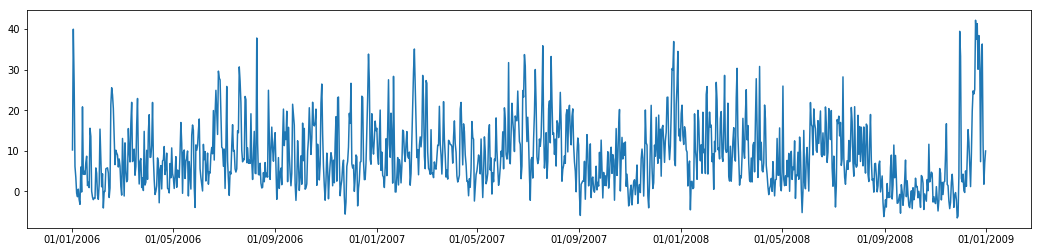

In [88]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 4)
mpl.rcParams['agg.path.chunksize'] = 10000
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.plot(x,y)